# Running simulations

Using all the ingredients from the previous notebook, we can now run simulations:

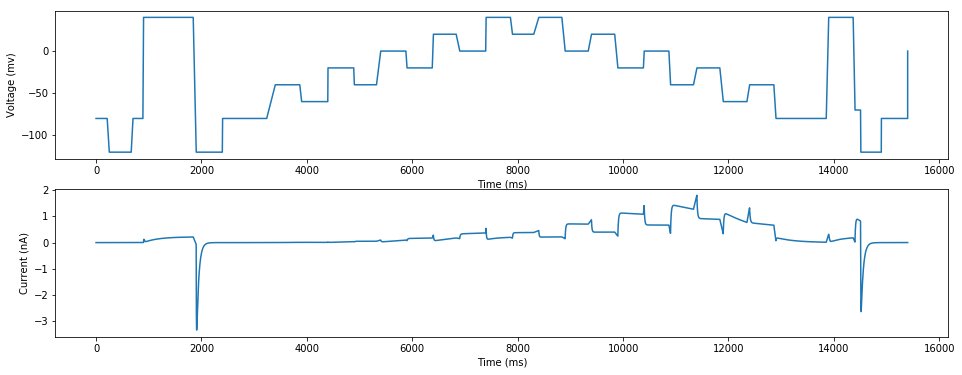

In [2]:
import matplotlib.pyplot as plt
import myokit

# Load the model
model = myokit.load_model('resources/beattie-2017-ikr-hh.mmt')

# Load the protocol
protocol = myokit.load_protocol('resources/simplified-staircase.mmt')

# Get the duration of the protocol
t_max = protocol.characteristic_time()

# Run a simulation from t=0 to t=t_max
s = myokit.Simulation(model, protocol)
log = s.run(t_max)

# Show the results
plt.figure(figsize=(16, 6))

plt.subplot(2, 1, 1)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mv)')
plt.plot(log['engine.time'], log['membrane.V'])

plt.subplot(2, 1, 2)
plt.xlabel('Time (ms)')
plt.ylabel('Current (nA)')
plt.plot(log['engine.time'], log['ikr.IKr'])

plt.show()

Success!

But there's still a few weird things going on: Some of the voltage steps seem to have ramps before or after them. And that annoying jump to 0mV is present at the final time point.
We can get a clearer view of what's going on by plotting in a slightly different way:

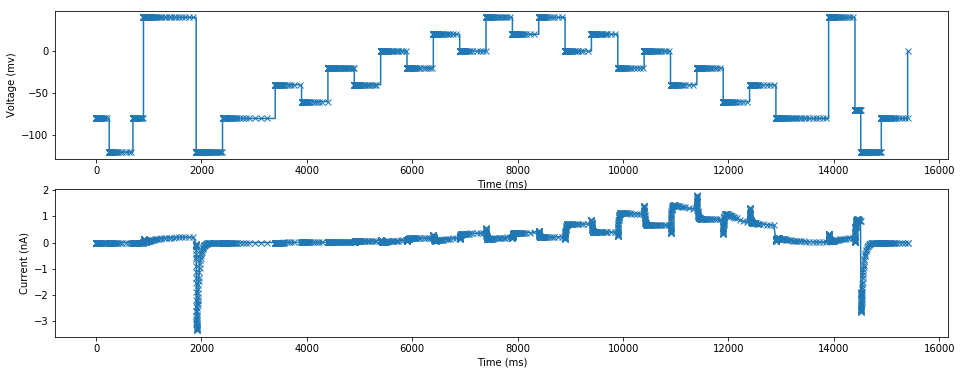

In [3]:
plt.figure(figsize=(16, 6))

plt.subplot(2, 1, 1)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mv)')

# Use the "steps-post" drawstyle for voltage
plt.plot(log['engine.time'], log['membrane.V'], 'x-', drawstyle='steps-post')

plt.subplot(2, 1, 2)
plt.xlabel('Time (ms)')
plt.ylabel('Current (nA)')

# Show the individual points for IKr
plt.plot(log['engine.time'], log['ikr.IKr'], 'x-')

plt.show()

The protocol looks a lot better now!
What's going on?

By using `simulation.run(t_max)` without any further arguments, we have not specified which points to log. 
As a result, the simulation just logs every point visited by the integration routine.
This has done exactly what we'd want, and visitied lots of points wherever the current changes fast, and only a handful of points where the current changed slowly.

The result is a set of points that's great for plotting smooth signals (e.g. the current), but not very good for plotting discontinuous signals (e.g. the protocol).
While the first point of each voltage step is guaranteed to be in the output, the last visited point before that can be anywhere, leading to the apparent ramps in the first plot.
To avoid these plotting artefacts, we can change the `matplotlib` "drawstyle" from "default" (connect any two points with a straight line) to "steps" (maintain the previous value until a new value is seen).

So nothing to worry about, but we need to be a bit careful when plotting!

When simulating an experiment, we'll usually want to control which points we store, i.e. to simulate measurements sampled with some fixed sampling rate:

First five times: [0.  0.1 0.2 0.3 0.4]
Last five times: [15399.5 15399.6 15399.7 15399.8 15399.9]


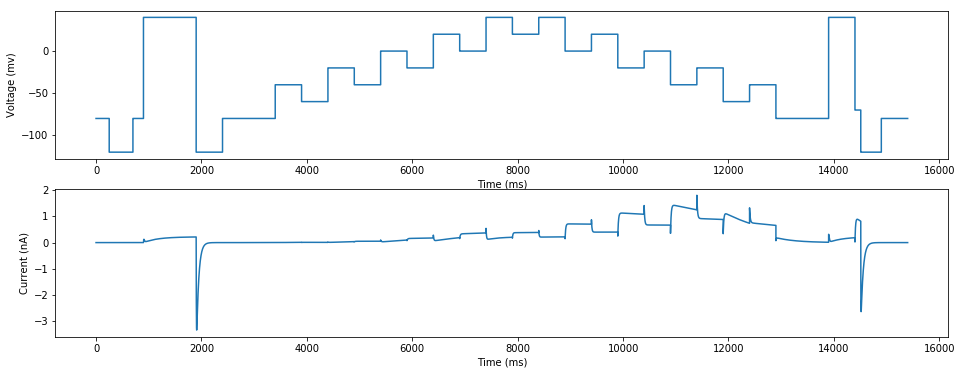

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import myokit

# Load the model
model = myokit.load_model('resources/beattie-2017-ikr-hh.mmt')

# Load the protocol
protocol = myokit.load_protocol('resources/simplified-staircase.mmt')

# Use a hard-coded t_max, that we got from an experimental file
t_max = 15400

# Use a hard-coded set of times to log
times = np.arange(0, t_max, 0.1)
print('First five times:', times[:5])
print('Last five times:', times[-5:])

# Run a simulation from t=0 to t=t_max
s = myokit.Simulation(model, protocol)
log = s.run(t_max, log_times=times)

# Show the results
plt.figure(figsize=(16, 6))

plt.subplot(2, 1, 1)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mv)')
plt.plot(log['engine.time'], log['membrane.V'], drawstyle='steps-post')

plt.subplot(2, 1, 2)
plt.xlabel('Time (ms)')
plt.ylabel('Current (nA)')
plt.plot(log['engine.time'], log['ikr.IKr'])

plt.show()

This looks good!

(Note that we're no longer logging the point `t=t_max`, so the final jump to 0mV has disappeared. See the [Introduction](./introduction.ipynb) for details.)

## A first optimisation: logging only the points we need

We can inspect the simulation log to see what else it contains:

In [5]:
print(len(log))
print(log.keys())

15
odict_keys(['ikr.act', 'ikr.rec', 'engine.time', 'membrane.V', 'ikr.IKr', 'ikr.act.inf', 'ikr.act.tau', 'ikr.act.k1', 'ikr.act.k2', 'ikr.rec.inf', 'ikr.rec.tau', 'ikr.rec.k3', 'ikr.rec.k4', 'dot(ikr.act)', 'dot(ikr.rec)'])


This shows us that 15 signals were logged.
Logging comes at a cost: For each logged signal an array is created, filled, and resized as necessary.
This happens so fast that we don't really care for most simulation work, but when fitting we might perform 1000s or 10000s of simulations, so it pays to speed things up a bit by only logging what we need.

To make the plot above, we only need time, voltage, and current.
During fitting we won't be interested in voltage, and if we're pre-specifiying the time (as in the example above) we don't need that either.
So we cangreatly reduce the amount of logged data as follows:

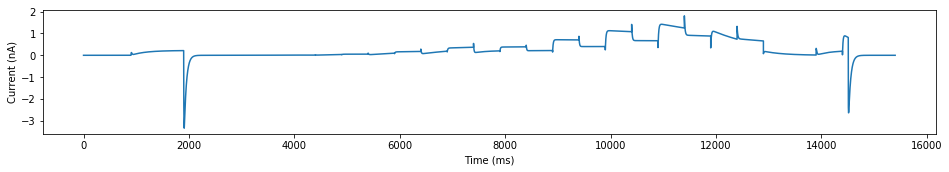

In [6]:
# Run a simulation from t=0 to t=t_max
s = myokit.Simulation(model, protocol)
log = s.run(t_max, log_times=times, log=['ikr.IKr'])

# Show the results
plt.figure(figsize=(16, 5))

plt.subplot(2, 1, 1)
plt.xlabel('Time (ms)')
plt.ylabel('Current (nA)')
plt.plot(times, log['ikr.IKr'])

plt.show()

### Parametrising the model

A key part in the fitting process will be changing the values of model parameter, running simulations, and comparing this to the real data.

One way to change model parameters in Myokit is by editing the model file itself.
But we can also modify parameters using the Model API:

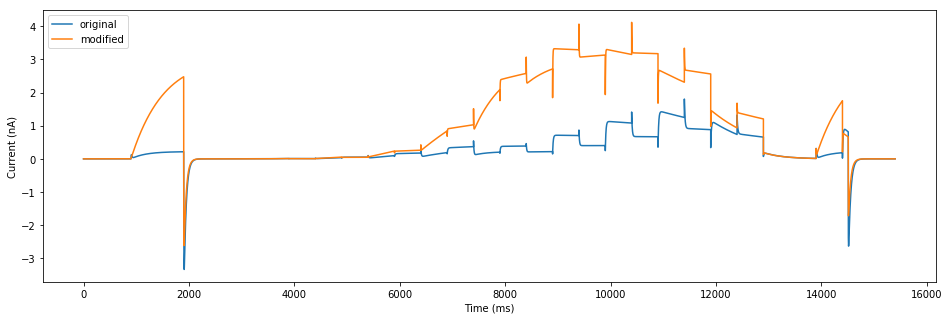

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import myokit

# Load the model
model = myokit.load_model('resources/beattie-2017-ikr-hh.mmt')

# Load the protocol
protocol = myokit.load_protocol('resources/simplified-staircase.mmt')

# Run a simulation
t_max = 15400
times = np.arange(0, t_max, 0.1)
s_1 = myokit.Simulation(model, protocol)
log_1 = s_1.run(t_max, log_times=times, log=['ikr.IKr'])

# Modify the model
p1 = model.get('ikr.p1')           # Get the objects representing model variables
p5 = model.get('ikr.p5')
p7 = model.get('ikr.p7')
p8 = model.get('ikr.p8')
p1.set_rhs(1e-4)                   # Set p1 to a predefined value
p5.set_rhs(2 * p5.eval())          # Set p5 to twice whatever it used to evaluate to
p7.set_rhs(myokit.Sqrt(p7.rhs()))  # Set p7 to a new value defined using myokit.Expression objects
p8.set_rhs('0.01 + p1^2')          # Set p8 to a new value defined by parsing a string

# Run another simulation
s_2 = myokit.Simulation(model, protocol)
log_2 = s_2.run(t_max, log_times=times, log=['ikr.IKr'])

# Show the results
plt.figure(figsize=(16, 5))
plt.xlabel('Time (ms)')
plt.ylabel('Current (nA)')
plt.plot(times, log_1['ikr.IKr'], label='original')
plt.plot(times, log_2['ikr.IKr'], label='modified')
plt.legend(loc='upper left')
plt.show()

This method of model parametrisation is very powerful: We can change the model entirely, even adding new parameters:

In [8]:
# Get the model component containing our current model
component = model.get('ikr')

# Add a new parameter
p10 = component.add_variable('p10')
p10.set_rhs(3)

# Change the equations to include this parameter
p8.set_rhs('1 / p10')

But a major downside to this method is that it requires us to create a new `Simulation` object after each change.
Behind the scenes, creating a `myokit.Simulation` involves code generation and compilation, so this is quite an expensive step!

### Optimisation: Modifying simulations, not models

In most cases, we don't need the flexibility of model manipulation and simply wish to change parameters defined as constants.
This can be done using the [Simulation.set_constant()](https://myokit.readthedocs.io/api_simulations/Simulation.html#myokit.Simulation.set_constant) method, which changes the value of a constant in a compiled simulation object:

Time taken: 0.7444201649996103
Time taken: 0.09371478400134947


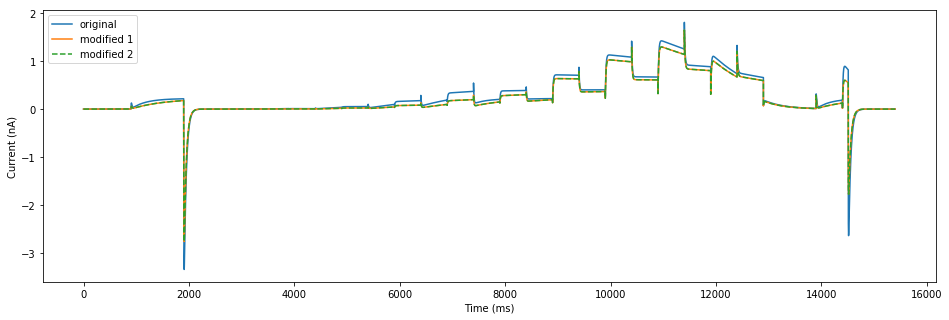

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import myokit

# Load the model
model = myokit.load_model('resources/beattie-2017-ikr-hh.mmt')

# Load the protocol
protocol = myokit.load_protocol('resources/simplified-staircase.mmt')

# Run a simulation
t_max = 15400
times = np.arange(0, t_max, 0.1)
s_1 = myokit.Simulation(model, protocol)
log_1 = s_1.run(t_max, log_times=times, log=['ikr.IKr'])

# Create a BenchMarker, to time the next operations
b = myokit.Benchmarker()

# Modify using the model API, and run a simulation
model.get('ikr.p1').set_rhs(1e-4)
s_2 = myokit.Simulation(model, protocol)
log_2 = s_2.run(t_max, log_times=times, log=['ikr.IKr'])
print('Time taken: ' + str(b.time()))

# Modify by changing a simulation object
b.reset()
s_1.reset()                       # Reset the first simulation to t=0
s_1.set_constant('ikr.p1', 1e-4)  # Update a parameter value
log_3 = s_1.run(t_max, log_times=times, log=['ikr.IKr'])
print('Time taken: ' + str(b.time()))

# Show the results
plt.figure(figsize=(16, 5))
plt.xlabel('Time (ms)')
plt.ylabel('Current (nA)')
plt.plot(times, log_1['ikr.IKr'], label='original')
plt.plot(times, log_2['ikr.IKr'], label='modified 1')
plt.plot(times, log_2['ikr.IKr'], '--', label='modified 2')
plt.legend(loc='upper left')
plt.show()

As the benchmarking results show, this is quite a bit faster, which is good when fitting!

You might notice we had to sneak an extra step in though: To re-use a simulation object for fitting, you need to call the `reset()` method to return it to its original state (time = 0 and using the initial conditions specified in the model file).

## Initial conditions?

The [Simulation.reset()](https://myokit.readthedocs.io/api_simulations/Simulation.html#myokit.Simulation.reset) method returns a simulation to its intial state: the time variable is set to zero and the model states are reset to their default values.
When a Simulation is created, these default values are set to the initial conditions of the simulation's [Model](https://myokit.readthedocs.io/api_core/Model.html), but they can be changed by calling [Simulation.set_default_state](https://myokit.readthedocs.io/api_simulations/Simulation.html#myokit.Simulation.set_default_state) or using [Simulation.pre()](https://myokit.readthedocs.io/api_simulations/Simulation.html#myokit.Simulation.pre).

So that's how we can set the initial conditions.
But what should they be?

One option could be to add the initial conditions as parameters to be identified by the optimisation.
This is a theoretically sound option, but, for our two-state model, adds two parameters to the optimisation problem (so it adds two dimensions to the search space!).

A cheaper alternative is to assume that the cell has been held at some fixed voltage between experiments, typically -80mV, so that the initial conditions will be very close to the steady state for that voltage.
There are two easy ways to achieve this in simulation.

### Mimicking the experiment: hold at -80mV and wait

The first method finds an approximate steady state, by holding at -80mV and just waiting.

The only tricky part about this method is that we have to remember that the membrane potential variable, `membrane.V`, has been "bound" to the simulation pacing variable, so that it can take values from the protocol:

```
[membrane]
V = 0 [mV] bind pace
```
This means that if we try to change its value, e.g. like this:
```
model.get('membrane.V').set_rhs(-80)
```
it won't have any effect, because the RHS for V will get overruled by the protocol (or set to 0 if no protocol is provided).

So in the example below, to set V to `-80mV`, we're going to also remove its binding to the 'pace' input, by calling [Variable.set_binding()](https://myokit.readthedocs.io/api_core/Variable.html#myokit.Variable.set_binding):

In [10]:
import myokit

# Load the model
model = myokit.load_model('resources/beattie-2017-ikr-hh.mmt')

# Get the model's activation and recovery variables
a = model.get('ikr.act')
r = model.get('ikr.rec')

# Set some unusual initial states, just to make the example more dramatic
a.set_state_value(0.5)
r.set_state_value(0.5)

# Set the model's membrane voltage to -80mV
v = model.get('membrane.V')
v.set_binding(None)
v.set_rhs(-80)

# Show the state derivatives
print('da/dt = ' + str(a.eval()))
print('dr/dt = ' + str(r.eval()))

# Create a simulation (without a protocol)
s = myokit.Simulation(model)

# Simulate for 2 minutes, showing the steady state after 10 seconds
print()
print(s.state())
for i in range(12):
    s.run(1000)
    print(s.state())
print()

# Update the model with these new steady states
x = s.state()
a.set_state_value(x[0])
r.set_state_value(x[1])

# Show the state derivatives
print('da/dt = ' + str(a.eval()))
print('dr/dt = ' + str(r.eval()))

da/dt = -0.001362536139948463
dr/dt = 0.010808852005550124

[0.5, 0.5]
[0.033020960832259534, 0.6008111994474178]
[0.0024456142450624482, 0.60081119944226]
[0.00045119129505045036, 0.60081119944226]
[0.00031785155456851466, 0.60081119944226]
[0.0003089887322983644, 0.60081119944226]
[0.00030896220740905307, 0.60081119944226]
[0.00030895385350906355, 0.60081119944226]
[0.00030895095692239316, 0.60081119944226]
[0.00030894990147123364, 0.60081119944226]
[0.00030894952220148023, 0.60081119944226]
[0.00030894938763211384, 0.60081119944226]
[0.0003089493404398138, 0.60081119944226]

da/dt = -6.782509513908989e-14
dr/dt = 0.0


By inspecting the state derivatives, we can see that the model is very nearly at steady state.

### Using the Hodgkin-Huxley equations

As an alternative to the simulations above, we can make use of the fact that we wrote our model in a Hodgkin-Huxley form, so that the steady states can be calculated directly:

In [11]:
import myokit

# Load the model
model = myokit.load_model('resources/beattie-2017-ikr-hh.mmt')

# Set the model's membrane voltage to -80mV
v = model.get('membrane.V')
v.set_binding(None)
v.set_rhs(-80)

# Get the model's activation and recovery variables
a = model.get('ikr.act')
r = model.get('ikr.rec')

# Get the steady-state variables for each
a_inf = model.get('ikr.act.inf')
r_inf = model.get('ikr.rec.inf')

# Show the steady state values
print('Steady state for activation: ' + str(a_inf.eval()))
print('Steady state for recovery  : ' + str(r_inf.eval()))

# Update the model with these new steady states
a.set_state_value(a_inf.eval())
r.set_state_value(r_inf.eval())

# Show the state derivatives
print('da/dt = ' + str(a.eval()))
print('dr/dt = ' + str(r.eval()))

Steady state for activation: 0.00030894931556590987
Steady state for recovery  : 0.60081119944226
da/dt = 0.0
dr/dt = 0.0


In the code above we changed the model so that we could evaluate the steady states at -80mV.
We can do the same without changing the model, by using the [Variable.pyfunc()](https://myokit.readthedocs.io/api_core/Variable.html?highlight=pyfunc#myokit.Variable.pyfunc) method.
This creates and returns a python function that evaluates a model variables' RHS (see the docs for details).

In [12]:
import myokit
import numpy as np
import matplotlib.pyplot as plt

# Load the model
model = myokit.load_model('resources/beattie-2017-ikr-hh.mmt')

# Get the model's activation and recovery variables
a = model.get('ikr.act')
r = model.get('ikr.rec')

# Get the steady-state variables for each
a_inf = model.get('ikr.act.inf')
r_inf = model.get('ikr.rec.inf')

# Get functions that evaluate the steady states
fa = a_inf.pyfunc()
fr = r_inf.pyfunc()

# Evalate both at -80mV
a_inf = fa(-80)
r_inf = fr(-80)
print('Steady state for activation: ' + str(a_inf))
print('Steady state for recovery  : ' + str(r_inf))

# Update the model with these new steady states
a.set_state_value(a_inf)
r.set_state_value(r_inf)

Steady state for activation: 0.00030894931556590987
Steady state for recovery  : 0.60081119944226


We can even use these generated functions to make some nice plots:

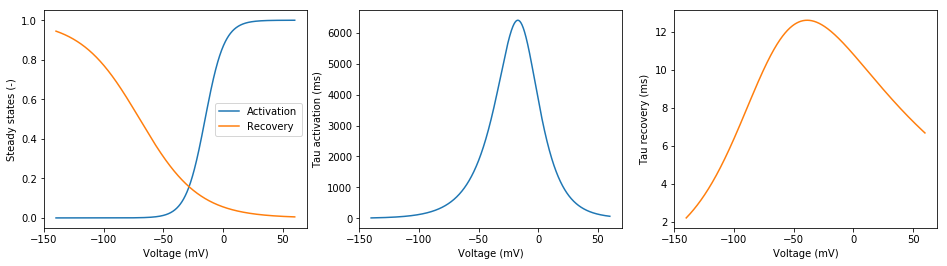

In [13]:
# Get functions that evaluate the steady states
a_inf = model.get('ikr.act.inf').pyfunc()
r_inf = model.get('ikr.rec.inf').pyfunc()

# Get functions that evaluate the time constants
tau_a = model.get('ikr.act.tau').pyfunc()
tau_r = model.get('ikr.rec.tau').pyfunc()

voltages = np.linspace(-140, 60, 1000)

plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
plt.xlabel('Voltage (mV)')
plt.ylabel('Steady states (-)')
plt.plot(voltages, a_inf(voltages), label='Activation')
plt.plot(voltages, r_inf(voltages), label='Recovery')
plt.legend()

plt.subplot(1, 3, 2)
plt.xlabel('Voltage (mV)')
plt.ylabel('Tau activation (ms)')
plt.plot(voltages, tau_a(voltages))

plt.subplot(1, 3, 3)
plt.xlabel('Voltage (mV)')
plt.ylabel('Tau recovery (ms)')
plt.plot(voltages, tau_r(voltages), color='tab:orange')

plt.show()

## Summary

In this part of the tutorial we have

- Run simulations with an ion current model and a voltage protocol
- Changed parameter values on the model, or directly on the simulation object
- Seen two ways to set a model's initial conditions to steady-state values

The next part of the tutorial shows you how to wrap these simulations into a PINTS 'model', and run fitting experiments.